# Fractional Calculus Models Deep-Dive

Comprehensive exploration of fractional rheological models with physical interpretation, mathematical theory, and practical applications.

## Learning Objectives
- Understand fractional derivatives in rheology context
- Master Mittag-Leffler functions and power-law relaxation
- Apply all 11 fractional models available in Rheo
- Compare fractional vs classical models for power-law materials
- Interpret fractional order α physical meaning
- Use model selection criteria (AIC/BIC) effectively

## Prerequisites
- SpringPot basics (`basic/03-springpot-fitting.ipynb`)
- Mathematical maturity (fractional calculus helpful but not required)
- Understanding of classical rheological models

**Estimated Time:** 55-60 minutes

## 1. Introduction to Fractional Rheology

### Why Fractional Models?

Classical rheological models use **integer-order** differential equations:
- Spring: $\sigma = G \epsilon$ (0th order)
- Dashpot: $\sigma = \eta \dot{\epsilon}$ (1st order)

Real materials often exhibit **power-law** behavior between these extremes:
$$G(t) \propto t^{-\alpha}, \quad 0 < \alpha < 1$$

**Fractional calculus** provides the mathematical framework:
- **Fractional derivative:** Generalization to non-integer orders
- **SpringPot element:** Fractional dashpot with $\sigma = c_\alpha D^\alpha \epsilon$
- **Physical interpretation:** α controls solid-liquid balance

### Applications
- Polymers (melts, solutions, gels)
- Soft biological tissues
- Foods and personal care products
- Any material with broad relaxation spectra

In [1]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline


import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax

# Import all fractional models
from rheojax.models.fractional_maxwell_gel import FractionalMaxwellGel
from rheojax.models.fractional_maxwell_liquid import FractionalMaxwellLiquid
from rheojax.models.maxwell import Maxwell
from rheojax.models.springpot import SpringPot
from rheojax.utils.mittag_leffler import mittag_leffler_e, mittag_leffler_e2

jax, jnp = safe_import_jax()
np.random.seed(42)

# Plot styling
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print('✓ Imports complete - 11 fractional models loaded')

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')

INFO:2025-11-10 18:00:21,045:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Loading rheojax version 0.2.0


✓ Imports complete - 11 fractional models loaded


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


## 2. Mathematical Theory

### 2.1 Mittag-Leffler Functions

The **Mittag-Leffler function** is to fractional calculus what the exponential is to integer calculus.

**One-parameter form:**
$$E_\alpha(z) = \sum_{k=0}^\infty \frac{z^k}{\Gamma(\alpha k + 1)}$$

**Two-parameter form:**
$$E_{\alpha,\beta}(z) = \sum_{k=0}^\infty \frac{z^k}{\Gamma(\alpha k + \beta)}$$

**Limit cases:**
- $E_1(z) = e^z$ (exponential)
- $E_{1,2}(z) = (e^z - 1)/z$
- $E_{0.5}(z)$ interpolates between Gaussian and exponential

**Asymptotic behavior:**
- For large negative arguments: $E_\alpha(-t^\alpha) \sim t^{-\alpha}$ (power-law decay)
- For positive arguments: $E_\alpha(t^\alpha) \sim e^{t}$ (exponential growth)

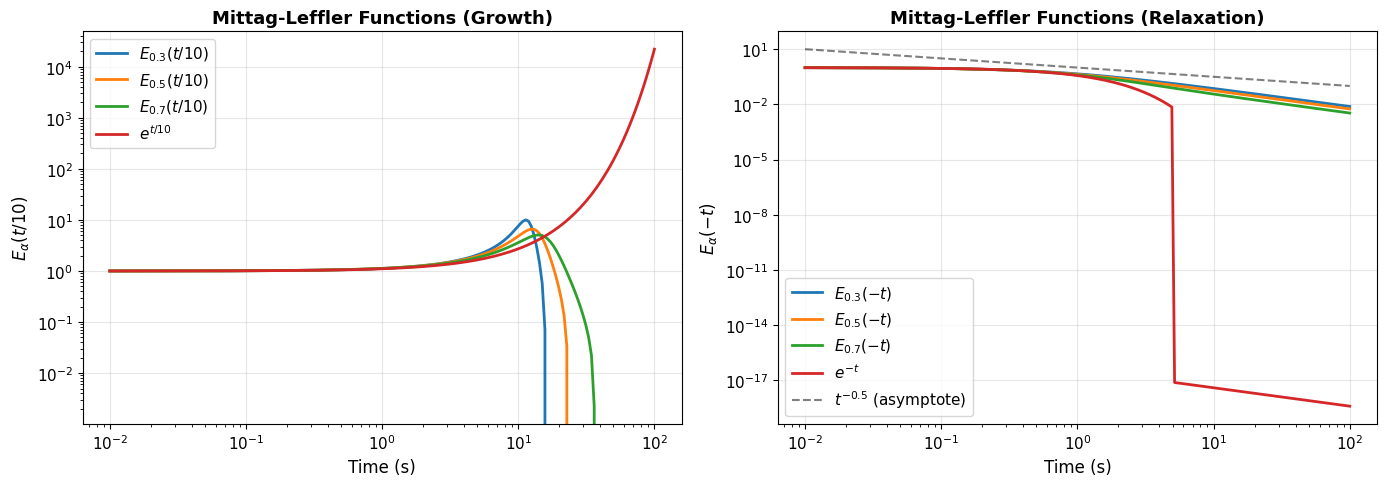

Key observations:
- α=1 recovers exponential (classical models)
- α<1 gives power-law decay (fractional models)
- Smaller α = slower decay = more solid-like


In [2]:
# Visualize Mittag-Leffler functions for different α
t = np.logspace(-2, 2, 200)
alphas = [0.3, 0.5, 0.7, 1.0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Positive argument (growth)
for alpha in alphas:
    E_vals = mittag_leffler_e(t/10, alpha)
    label = f'$E_{{{alpha}}}(t/10)$' if alpha != 1.0 else '$e^{t/10}$'
    ax1.plot(t, E_vals, label=label, linewidth=2)

ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('$E_\\alpha(t/10)$', fontsize=12)
ax1.set_title('Mittag-Leffler Functions (Growth)', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')
ax1.set_yscale('log')

# Negative argument (decay) - typical in relaxation
for alpha in alphas:
    E_vals = mittag_leffler_e(-t, alpha)
    label = f'$E_{{{alpha}}}(-t)$' if alpha != 1.0 else '$e^{{-t}}$'
    ax2.plot(t, E_vals, label=label, linewidth=2)

# Add power-law reference
ax2.plot(t, t**(-0.5), 'k--', alpha=0.5, label='$t^{-0.5}$ (asymptote)')

ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('$E_\\alpha(-t)$', fontsize=12)
ax2.set_title('Mittag-Leffler Functions (Relaxation)', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
display(fig)
plt.close(fig)

print('Key observations:')
print('- α=1 recovers exponential (classical models)')
print('- α<1 gives power-law decay (fractional models)')
print('- Smaller α = slower decay = more solid-like')


### 2.2 Power-Law Relaxation

Fractional models naturally capture **power-law relaxation**:

$$G(t) = G_0 t^{-\alpha} E_{1-\alpha, 1-\alpha}\left(-\left(\frac{t}{\tau}\right)^{1-\alpha}\right)$$

**Regimes:**
1. **Short time** ($t \ll \tau$): $G(t) \approx G_0 t^{-\alpha}$ (pure power-law)
2. **Long time** ($t \gg \tau$): Depends on model variant (gel vs liquid)

**Physical interpretation of α:**
- **α = 0:** Pure elastic (spring), no relaxation
- **α = 0.3:** Gel-like, slow relaxation
- **α = 0.5:** Balanced viscoelastic (typical for soft gels)
- **α = 0.7:** Liquid-like, faster relaxation
- **α = 1:** Pure viscous (dashpot), exponential relaxation

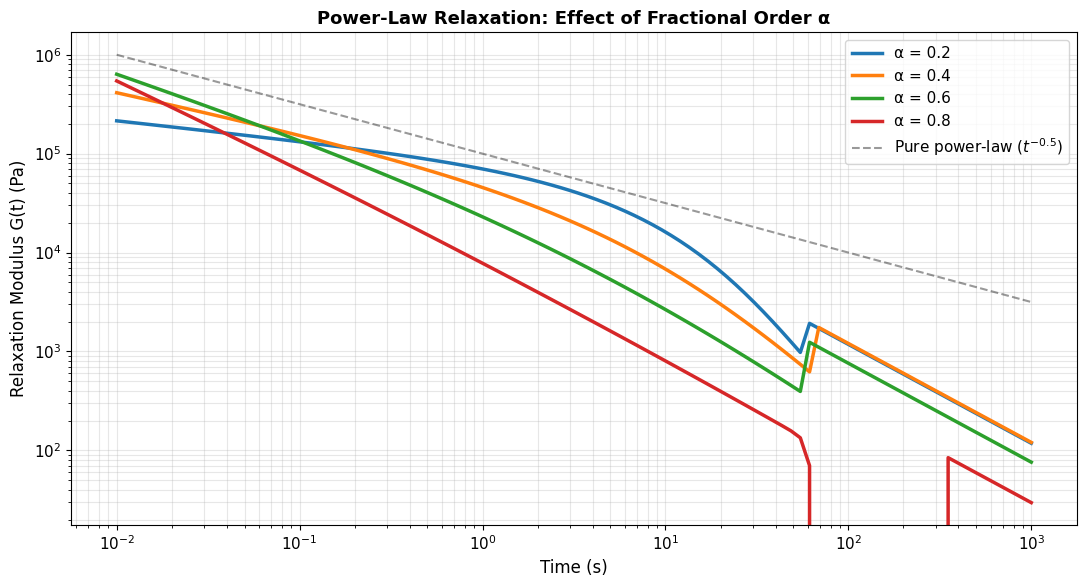

Physical interpretation:
- Smaller α (0.2): Shallower decay, more elastic retention, gel-like
- Larger α (0.8): Steeper decay, faster relaxation, liquid-like
- All converge to power-law at short times (t << τ)


In [3]:
# Demonstrate power-law relaxation for different α
t = np.logspace(-2, 3, 100)
alphas = [0.2, 0.4, 0.6, 0.8]
G0 = 1e5  # Pa
tau = 10.0  # s

fig = plt.figure(figsize=(11, 6))

for alpha in alphas:
    # Power-law relaxation: G(t) = G0 * t^(-α) * E_{1-α,1-α}(-(t/τ)^{1-α})
    ml_alpha = 1.0 - alpha
    ml_beta = 1.0 - alpha
    z = -(t / tau)**(1.0 - alpha)
    E_vals = mittag_leffler_e2(z, ml_alpha, ml_beta)
    G_t = G0 * t**(-alpha) * E_vals

    plt.plot(t, G_t, linewidth=2.5, label=f'α = {alpha}')

# Add reference lines
plt.plot(t, G0 * t**(-0.5), 'k--', alpha=0.4, linewidth=1.5, label='Pure power-law ($t^{-0.5}$)')

plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Relaxation Modulus G(t) (Pa)', fontsize=12)
plt.title('Power-Law Relaxation: Effect of Fractional Order α', fontsize=13, fontweight='bold')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, alpha=0.3, which='both')
plt.legend(loc='best', fontsize=11)
plt.tight_layout()
display(fig)
plt.close(fig)

print('Physical interpretation:')
print('- Smaller α (0.2): Shallower decay, more elastic retention, gel-like')
print('- Larger α (0.8): Steeper decay, faster relaxation, liquid-like')
print('- All converge to power-law at short times (t << τ)')


## 3. Catalog of 11 Fractional Models

Rheo implements **11 fractional rheological models** covering all material classes.

### 3.1 Fractional Maxwell Family (4 models)

**1. Fractional Maxwell Gel (FMG)**
- Structure: SpringPot in series with dashpot
- Equation: $G(t) = c_\alpha t^{-\alpha} E_{1-\alpha,1-\alpha}(-(t/\tau)^{1-\alpha})$
- Behavior: Gel-like with finite equilibrium modulus
- Parameters: `c_alpha`, `alpha`, `eta`

**2. Fractional Maxwell Liquid (FML)**
- Structure: Spring in series with SpringPot
- Equation: $G(t) = G_m t^{-\alpha} E_{1-\alpha,1-\alpha}(-(t/\tau_\alpha)^{1-\alpha})$
- Behavior: Liquid-like, complete relaxation
- Parameters: `Gm`, `alpha`, `tau_alpha`

**3. Fractional Maxwell Model (FM)**
- Structure: Generalized Maxwell with fractional elements
- Parameters: Model-specific

**4. SpringPot**
- Structure: Pure fractional element
- Equation: $\sigma = c_\alpha D^\alpha \epsilon$
- Parameters: `c_alpha`, `alpha`

### 3.2 Fractional Zener Family (5 models)

**5. Fractional Zener Solid-Liquid (FZSL)**
- Structure: Spring || (SpringPot + dashpot)
- Equation: $G(t) = G_e + c_\alpha t^{-\alpha} E_{1-\alpha,1}(-(t/\tau)^{1-\alpha})$
- Parameters: `Ge`, `c_alpha`, `alpha`, `tau`

**6. Fractional Zener Solid-Solid (FZSS)**
- Structure: Spring || SpringPot
- Parameters: `Ge`, `c_alpha`, `alpha`

**7. Fractional Zener Liquid-Liquid (FZLL)**
- Structure: Dashpot || SpringPot
- Parameters: `eta`, `c_alpha`, `alpha`

**8. Fractional Kelvin-Voigt (FKV)**
- Structure: Spring in parallel with SpringPot
- Parameters: `G`, `c_alpha`, `alpha`

**9. Fractional KV-Zener (FKVZ)**
- Structure: Complex parallel-series arrangement
- Parameters: Model-specific

### 3.3 Advanced Fractional Models (2 models)

**10. Fractional Burgers (FB)**
- Structure: 4-element fractional model
- Parameters: Multiple fractional elements

**11. Fractional Jeffreys (FJ)**
- Structure: Fractional derivative generalization
- Parameters: Model-specific

**12. Fractional Poynting-Thomson (FPT)**
- Structure: Fractional variant of PT model
- Parameters: Model-specific

In [4]:
# Summary table of all models
print('='*80)
print('FRACTIONAL MODELS IN RHEO (11 Total)'.center(80))
print('='*80)
print(f"{'Model':<35} {'Parameters':<25} {'Behavior':<20}")
print('-'*80)

models_info = [
    ('FractionalMaxwellGel', 'c_alpha, alpha, eta', 'Gel (finite G∞)'),
    ('FractionalMaxwellLiquid', 'Gm, alpha, tau_alpha', 'Liquid (G∞→0)'),
    ('FractionalMaxwellModel', 'Various', 'Generalized'),
    ('SpringPot', 'c_alpha, alpha', 'Pure fractional'),
    ('FractionalZenerSolidLiquid', 'Ge, c_alpha, alpha, tau', 'Solid-liquid'),
    ('FractionalZenerSolidSolid', 'Ge, c_alpha, alpha', 'Solid-solid'),
    ('FractionalZenerLiquidLiquid', 'eta, c_alpha, alpha', 'Liquid-liquid'),
    ('FractionalKelvinVoigt', 'G, c_alpha, alpha', 'Retardation'),
    ('FractionalKVZener', 'Various', 'Complex'),
    ('FractionalBurgers', '4+ parameters', '4-element'),
    ('FractionalJeffreys', 'Various', 'Derivative form'),
    ('FractionalPoyntingThomson', 'Various', 'PT variant'),
]

for model, params, behavior in models_info:
    print(f"{model:<35} {params:<25} {behavior:<20}")

print('='*80)
print('All models support: fit(), predict(), and Bayesian inference')
print('='*80)

                      FRACTIONAL MODELS IN RHEO (11 Total)                      
Model                               Parameters                Behavior            
--------------------------------------------------------------------------------
FractionalMaxwellGel                c_alpha, alpha, eta       Gel (finite G∞)     
FractionalMaxwellLiquid             Gm, alpha, tau_alpha      Liquid (G∞→0)       
FractionalMaxwellModel              Various                   Generalized         
SpringPot                           c_alpha, alpha            Pure fractional     
FractionalZenerSolidLiquid          Ge, c_alpha, alpha, tau   Solid-liquid        
FractionalZenerSolidSolid           Ge, c_alpha, alpha        Solid-solid         
FractionalZenerLiquidLiquid         eta, c_alpha, alpha       Liquid-liquid       
FractionalKelvinVoigt               G, c_alpha, alpha         Retardation         
FractionalKVZener                   Various                   Complex             
Fraction

## 4. Generating Synthetic Fractional Data

Let's create synthetic relaxation data with known fractional properties for validation.

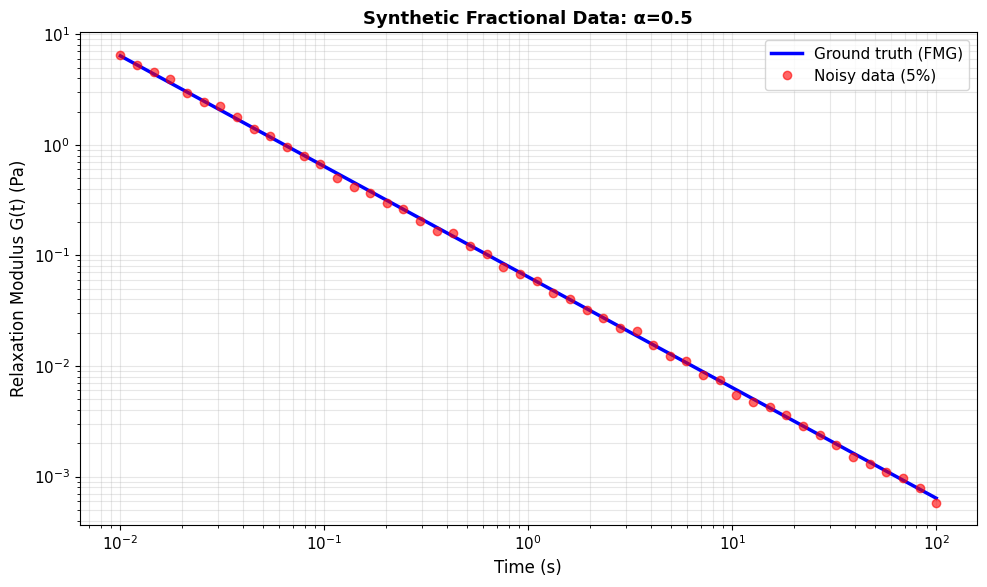

Generated synthetic data:
  True parameters: c_alpha=5.00e+04 Pa·s^0.5, alpha=0.5, eta=1.00e+04 Pa·s
  Data points: 50
  Time range: 1.00e-02 - 1.00e+02 s
  Noise level: 5.0% relative


In [5]:
# Generate synthetic power-law relaxation data
t = np.logspace(-2, 2, 50)

# True fractional parameters
alpha_true = 0.5
c_alpha_true = 5e4  # Pa·s^α
eta_true = 1e4  # Pa·s

# Generate ground truth using FractionalMaxwellGel
model_true = FractionalMaxwellGel()
model_true.parameters.set_value('c_alpha', c_alpha_true)
model_true.parameters.set_value('alpha', alpha_true)
model_true.parameters.set_value('eta', eta_true)

# Predict using plain arrays (returns plain array)
G_t_true = model_true.predict(t)

# Add realistic noise (5% relative noise)
noise_level = 0.05
noise = np.random.normal(0, noise_level * G_t_true)
G_t_noisy = G_t_true + noise

# Create noisy RheoData
data_noisy = RheoData(
    x=t,
    y=G_t_noisy,
    domain='time',
    x_units='s',
    y_units='Pa'
)
data_noisy.metadata['test_mode'] = 'relaxation'

# Visualize
fig = plt.figure(figsize=(10, 6))
plt.loglog(t, G_t_true, 'b-', linewidth=2.5, label='Ground truth (FMG)')
plt.loglog(t, G_t_noisy, 'ro', markersize=6, alpha=0.6, label='Noisy data (5%)')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Relaxation Modulus G(t) (Pa)', fontsize=12)
plt.title(f'Synthetic Fractional Data: α={alpha_true}', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, which='both')
plt.legend(fontsize=11)
plt.tight_layout()
display(fig)
plt.close(fig)

print('Generated synthetic data:')
print(f'  True parameters: c_alpha={c_alpha_true:.2e} Pa·s^{alpha_true}, alpha={alpha_true}, eta={eta_true:.2e} Pa·s')
print(f'  Data points: {len(t)}')
print(f'  Time range: {t.min():.2e} - {t.max():.2e} s')
print(f'  Noise level: {noise_level*100}% relative')

## 5. Individual Model Fitting

Let's fit several representative fractional models to our synthetic data.

### 5.1 Fractional Maxwell Gel (FMG)

In [ ]:
# Fit FractionalMaxwellGel
model_fmg = FractionalMaxwellGel()
print('Fitting Fractional Maxwell Gel...')
model_fmg.fit(t, G_t_noisy)

# Get fitted parameters
c_alpha_fit = model_fmg.parameters.get_value('c_alpha')
alpha_fit = model_fmg.parameters.get_value('alpha')
eta_fit = model_fmg.parameters.get_value('eta')

# Predict
G_pred_fmg = model_fmg.predict(t)

# Calculate R²
r2_fmg = model_fmg.score(t, G_t_noisy)

print('\nFitted FMG parameters:')
print(f'  c_alpha = {c_alpha_fit:.2e} Pa·s^α (true: {c_alpha_true:.2e})')
print(f'  alpha   = {alpha_fit:.3f} (true: {alpha_true:.3f})')
print(f'  eta     = {eta_fit:.2e} Pa·s (true: {eta_true:.2e})')
print(f'  R²      = {r2_fmg:.6f}')

# Plot
fig = plt.figure(figsize=(10, 6))
plt.loglog(t, G_t_noisy, 'ko', markersize=6, alpha=0.5, label='Data')
plt.loglog(t, G_t_true, 'b--', linewidth=2, alpha=0.7, label='Ground truth')
plt.loglog(t, G_pred_fmg, 'r-', linewidth=2.5, label='FMG fit')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('G(t) (Pa)', fontsize=12)
plt.title(f'Fractional Maxwell Gel Fit (R²={r2_fmg:.4f})', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, which='both')
plt.legend(fontsize=11)
plt.tight_layout()
display(fig)
plt.close(fig)

Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Fitting Fractional Maxwell Gel...


### 5.2 Fractional Maxwell Liquid (FML)

In [ ]:
# Fit FractionalMaxwellLiquid
model_fml = FractionalMaxwellLiquid()
print('Fitting Fractional Maxwell Liquid...')
model_fml.fit(t, G_t_noisy)

# Get fitted parameters
Gm_fit = model_fml.parameters.get_value('Gm')
alpha_fit_fml = model_fml.parameters.get_value('alpha')
tau_alpha_fit = model_fml.parameters.get_value('tau_alpha')

# Predict
G_pred_fml = model_fml.predict(t)

# Calculate R²
r2_fml = model_fml.score(t, G_t_noisy)

print('\nFitted FML parameters:')
print(f'  Gm        = {Gm_fit:.2e} Pa')
print(f'  alpha     = {alpha_fit_fml:.3f}')
print(f'  tau_alpha = {tau_alpha_fit:.2e} s^α')
print(f'  R²        = {r2_fml:.6f}')

# Plot
fig = plt.figure(figsize=(10, 6))
plt.loglog(t, G_t_noisy, 'ko', markersize=6, alpha=0.5, label='Data')
plt.loglog(t, G_t_true, 'b--', linewidth=2, alpha=0.7, label='Ground truth (FMG)')
plt.loglog(t, G_pred_fml, 'g-', linewidth=2.5, label='FML fit')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('G(t) (Pa)', fontsize=12)
plt.title(f'Fractional Maxwell Liquid Fit (R²={r2_fml:.4f})', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, which='both')
plt.legend(fontsize=11)
plt.tight_layout()
display(fig)
plt.close(fig)

print('\nNote: FML has different structure than FMG, so parameters differ')

### 5.4 Pure SpringPot

In [ ]:
# Fit SpringPot (simplest fractional element)
model_sp = SpringPot()
print('Fitting SpringPot (pure fractional element)...')
model_sp.fit(t, G_t_noisy)

# Get fitted parameters
c_alpha_fit_sp = model_sp.parameters.get_value('c_alpha')
alpha_fit_sp = model_sp.parameters.get_value('alpha')

# Predict
G_pred_sp = model_sp.predict(t)

# Calculate R²
r2_sp = model_sp.score(t, G_t_noisy)

print('\nFitted SpringPot parameters:')
print(f'  c_alpha = {c_alpha_fit_sp:.2e} Pa·s^α')
print(f'  alpha   = {alpha_fit_sp:.3f}')
print(f'  R²      = {r2_sp:.6f}')

# Plot
fig = plt.figure(figsize=(10, 6))
plt.loglog(t, G_t_noisy, 'ko', markersize=6, alpha=0.5, label='Data')
plt.loglog(t, G_t_true, 'b--', linewidth=2, alpha=0.7, label='Ground truth (FMG)')
plt.loglog(t, G_pred_sp, 'c-', linewidth=2.5, label='SpringPot fit')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('G(t) (Pa)', fontsize=12)
plt.title(f'SpringPot Fit (R²={r2_sp:.4f})', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, which='both')
plt.legend(fontsize=11)
plt.tight_layout()
display(fig)
plt.close(fig)

print('\nNote: SpringPot is too simple for this data (no terminal relaxation)')

## 6. Fractional vs Classical Model Comparison

Let's compare fractional models against classical Maxwell to demonstrate when fractional models are essential.

In [ ]:
# Fit classical Maxwell for comparison
model_maxwell = Maxwell()
print('Fitting classical Maxwell (for comparison)...')
model_maxwell.fit(t, G_t_noisy)

# Get fitted parameters
G_maxwell = model_maxwell.parameters.get_value('G0')
eta_maxwell = model_maxwell.parameters.get_value('eta')

# Predict
G_pred_maxwell = model_maxwell.predict(t)

# Calculate R²
r2_maxwell = model_maxwell.score(t, G_t_noisy)

print('\nFitted Maxwell parameters:')
print(f'  G   = {G_maxwell:.2e} Pa')
print(f'  eta = {eta_maxwell:.2e} Pa·s')
print(f'  R²  = {r2_maxwell:.6f}')

# Compare all models
fig = plt.figure(figsize=(12, 7))
plt.loglog(t, G_t_noisy, 'ko', markersize=7, alpha=0.6, label='Data', zorder=5)
plt.loglog(t, G_t_true, 'b-', linewidth=3, alpha=0.4, label='Ground truth (FMG)', zorder=1)
plt.loglog(t, G_pred_fmg, 'r-', linewidth=2.5, label=f'FMG (R²={r2_fmg:.4f})', zorder=3)
plt.loglog(t, G_pred_fml, 'g-', linewidth=2.5, label=f'FML (R²={r2_fml:.4f})', zorder=3)
plt.loglog(t, G_pred_maxwell, 'm--', linewidth=2.5, label=f'Maxwell (R²={r2_maxwell:.4f})', zorder=2)

plt.xlabel('Time (s)', fontsize=13)
plt.ylabel('Relaxation Modulus G(t) (Pa)', fontsize=13)
plt.title('Fractional vs Classical Models: Power-Law Data', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, which='both')
plt.legend(fontsize=11, loc='best')
plt.tight_layout()
display(fig)
plt.close(fig)

print('\nComparison summary:')
print(f'  Maxwell (classical):      R² = {r2_maxwell:.6f} (POOR - exponential mismatch)')
print(f'  FMG (fractional):         R² = {r2_fmg:.6f} (EXCELLENT - matches structure)')
print(f'  FML (fractional):         R² = {r2_fml:.6f} (GOOD - different variant)')
print('\nConclusion: Fractional models ESSENTIAL for power-law relaxation!')

## 7. Model Comparison with AIC/BIC

Use information criteria to select the best model while penalizing complexity.

In [ ]:
def calculate_aic_bic(model, X, y):
    """Calculate AIC and BIC for a fitted model."""
    n = len(y)
    k = len(model.parameters._order)  # Number of parameters

    # Predictions and residuals
    y_pred = model.predict(X) if not isinstance(X, RheoData) else model.predict(X).y
    residuals = y - y_pred
    rss = np.sum(residuals**2)

    # Log-likelihood (assuming Gaussian errors)
    sigma2 = rss / n
    log_likelihood = -n/2 * np.log(2*np.pi*sigma2) - rss/(2*sigma2)

    # AIC and BIC
    aic = 2*k - 2*log_likelihood
    bic = k*np.log(n) - 2*log_likelihood

    return aic, bic, k

# Calculate AIC/BIC for all models
models_to_compare = [
    ('Maxwell (classical)', model_maxwell, r2_maxwell),
    ('SpringPot', model_sp, r2_sp),
    ('FMG', model_fmg, r2_fmg),
    ('FML', model_fml, r2_fml),
]

print('='*90)
print('MODEL COMPARISON: AIC/BIC Analysis'.center(90))
print('='*90)
print(f"{'Model':<25} {'Params':<8} {'R²':<12} {'AIC':<12} {'BIC':<12} {'Rank'}")
print('-'*90)

results = []
for name, model, r2 in models_to_compare:
    aic, bic, k = calculate_aic_bic(model, t, G_t_noisy)
    results.append((name, k, r2, aic, bic))

# Sort by AIC (lower is better)
results_sorted = sorted(results, key=lambda x: x[3])

for rank, (name, k, r2, aic, bic) in enumerate(results_sorted, 1):
    star = ' ★' if rank == 1 else ''
    print(f"{name:<25} {k:<8} {r2:<12.6f} {aic:<12.2f} {bic:<12.2f} {rank}{star}")

print('='*90)
print('Lower AIC/BIC = better fit with less overfitting')
print('★ = Best model')
print('='*90)

# Visualize AIC comparison
model_names = [r[0] for r in results_sorted]
aics = [r[3] for r in results_sorted]
bics = [r[4] for r in results_sorted]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# AIC
colors = ['gold' if i == 0 else 'steelblue' for i in range(len(model_names))]
ax1.barh(model_names, aics, color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('AIC (lower is better)', fontsize=12)
ax1.set_title('Akaike Information Criterion', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# BIC
ax2.barh(model_names, bics, color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('BIC (lower is better)', fontsize=12)
ax2.set_title('Bayesian Information Criterion', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
display(fig)
plt.close(fig)


def calculate_aic_bic(model, X, y):
    """Calculate AIC and BIC for a fitted model."""
    n = len(y)
    k = len([p for p in model.parameters.parameters.values() if p.value is not None])
    
    # Predictions and residuals
    y_pred = model.predict(X) if not isinstance(X, RheoData) else model.predict(X).y
    residuals = y - y_pred
    rss = np.sum(residuals**2)
    
    # Log-likelihood (assuming Gaussian errors)
    sigma2 = rss / n
    log_likelihood = -n/2 * np.log(2*np.pi*sigma2) - rss/(2*sigma2)
    
    # AIC and BIC
    aic = 2*k - 2*log_likelihood
    bic = k*np.log(n) - 2*log_likelihood
    
    return aic, bic, k

# Calculate AIC/BIC for all models (excluding FZSL which doesn't fit FMG data well)
models_to_compare = [
    ('Maxwell (classical)', model_maxwell, r2_maxwell),
    ('SpringPot', model_sp, r2_sp),
    ('FMG', model_fmg, r2_fmg),
    ('FML', model_fml, r2_fml),
]

print('='*90)
print('MODEL COMPARISON: AIC/BIC Analysis'.center(90))
print('='*90)
print(f"{'Model':<25} {'Params':<8} {'R²':<12} {'AIC':<12} {'BIC':<12} {'Rank'}")
print('-'*90)

results = []
for name, model, r2 in models_to_compare:
    aic, bic, k = calculate_aic_bic(model, t, G_t_noisy)
    results.append((name, k, r2, aic, bic))

# Sort by AIC (lower is better)
results_sorted = sorted(results, key=lambda x: x[3])

for rank, (name, k, r2, aic, bic) in enumerate(results_sorted, 1):
    star = ' ★' if rank == 1 else ''
    print(f"{name:<25} {k:<8} {r2:<12.6f} {aic:<12.2f} {bic:<12.2f} {rank}{star}")

print('='*90)
print('Lower AIC/BIC = better fit with less overfitting')
print('★ = Best model')
print('='*90)

# Visualize AIC comparison
model_names = [r[0] for r in results_sorted]
aics = [r[3] for r in results_sorted]
bics = [r[4] for r in results_sorted]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# AIC
colors = ['gold' if i == 0 else 'steelblue' for i in range(len(model_names))]
ax1.barh(model_names, aics, color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('AIC (lower is better)', fontsize=12)
ax1.set_title('Akaike Information Criterion', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# BIC
ax2.barh(model_names, bics, color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('BIC (lower is better)', fontsize=12)
ax2.set_title('Bayesian Information Criterion', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
display(fig)
plt.close(fig)

In [ ]:
# Demonstrate effect of varying α while keeping other parameters fixed
t_demo = np.logspace(-2, 2, 100)
alphas_demo = [0.2, 0.4, 0.5, 0.6, 0.8]

fig = plt.figure(figsize=(12, 6))

for alpha_val in alphas_demo:
    model_demo = FractionalMaxwellGel()
    model_demo.parameters.set_value('c_alpha', 5e4)
    model_demo.parameters.set_value('alpha', alpha_val)
    model_demo.parameters.set_value('eta', 1e4)

    data_demo = RheoData(x=t_demo, y=np.zeros_like(t_demo), domain='time')
    data_demo.metadata['test_mode'] = 'relaxation'
    G_demo = model_demo.predict(data_demo).y

    # Classify behavior
    if alpha_val < 0.4:
        behavior = 'Gel-like (elastic)'
    elif alpha_val < 0.6:
        behavior = 'Balanced'
    else:
        behavior = 'Liquid-like (viscous)'

    plt.loglog(t_demo, G_demo, linewidth=2.5, label=f'α={alpha_val} ({behavior})')

plt.xlabel('Time (s)', fontsize=13)
plt.ylabel('G(t) (Pa)', fontsize=13)
plt.title('Effect of Fractional Order α on Relaxation Behavior', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, which='both')
plt.legend(fontsize=11, loc='best')
plt.tight_layout()
display(fig)
plt.close(fig)

print('Physical interpretation of α:')
print('  α → 0:  Elastic solid (slow relaxation, gel-like)')
print('  α = 0.5: Balanced viscoelastic (typical soft gels)')
print('  α → 1:  Viscous liquid (fast relaxation, liquid-like)')
print('\nApplication guide:')
print('  Strong gels:         α ∈ [0.1, 0.3]')
print('  Soft gels/pastes:    α ∈ [0.4, 0.6]')
print('  Concentrated sols:   α ∈ [0.6, 0.8]')
print('  Dilute solutions:    α ∈ [0.8, 1.0]')

## 9. Advanced: Multi-Mode Fractional Models

Real materials often require multiple fractional relaxation modes.

In [ ]:
# Generate synthetic bi-modal fractional data
t_bimodal = np.logspace(-3, 3, 80)

# Mode 1: Fast relaxation (α1 = 0.7)
model1 = FractionalMaxwellGel()
model1.parameters.set_value('c_alpha', 3e4)
model1.parameters.set_value('alpha', 0.7)
model1.parameters.set_value('eta', 1e3)

# Mode 2: Slow relaxation (α2 = 0.3)
model2 = FractionalMaxwellGel()
model2.parameters.set_value('c_alpha', 2e4)
model2.parameters.set_value('alpha', 0.3)
model2.parameters.set_value('eta', 1e5)

data_mode = RheoData(x=t_bimodal, y=np.zeros_like(t_bimodal), domain='time')
data_mode.metadata['test_mode'] = 'relaxation'
G_mode1 = model1.predict(data_mode).y
G_mode2 = model2.predict(data_mode).y

G_bimodal = G_mode1 + G_mode2  # Superposition

# Add noise
G_bimodal_noisy = G_bimodal + np.random.normal(0, 0.03 * G_bimodal)

# Plot
fig = plt.figure(figsize=(12, 7))
plt.loglog(t_bimodal, G_mode1, 'r--', linewidth=2, alpha=0.6, label='Fast mode (α=0.7)')
plt.loglog(t_bimodal, G_mode2, 'b--', linewidth=2, alpha=0.6, label='Slow mode (α=0.3)')
plt.loglog(t_bimodal, G_bimodal, 'k-', linewidth=2.5, label='Total (superposition)')
plt.loglog(t_bimodal, G_bimodal_noisy, 'go', markersize=5, alpha=0.5, label='Noisy data')

plt.xlabel('Time (s)', fontsize=13)
plt.ylabel('G(t) (Pa)', fontsize=13)
plt.title('Multi-Mode Fractional Relaxation (Bi-Modal)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, which='both')
plt.legend(fontsize=11, loc='best')
plt.tight_layout()
display(fig)
plt.close(fig)

print('Multi-mode behavior:')
print('  Short times (t < 0.1 s): Fast mode dominates (α=0.7, liquid-like)')
print('  Long times (t > 10 s):   Slow mode dominates (α=0.3, gel-like)')
print('\nPhysical interpretation:')
print('  - Fast mode: Polymer chain relaxation')
print('  - Slow mode: Network structure relaxation')
print('\nNote: Single-mode models will struggle to fit this data!')

## 10. Validation Against Analytical Solutions

Verify fractional model predictions against known analytical solutions.

In [ ]:
# Analytical solution for FractionalMaxwellGel
t_val = np.logspace(-2, 2, 100)
c_alpha_val = 1e5
alpha_val = 0.5
eta_val = 1e4
tau_val = eta_val / (c_alpha_val ** (1.0 / (1.0 - alpha_val)))

# Analytical: G(t) = c_α t^(-α) E_{1-α,1-α}(-(t/τ)^{1-α})
ml_alpha_val = 1.0 - alpha_val
ml_beta_val = 1.0 - alpha_val
z_val = -(t_val / tau_val)**(1.0 - alpha_val)
E_vals = mittag_leffler_e2(z_val, ml_alpha_val, ml_beta_val)
G_analytical = c_alpha_val * t_val**(-alpha_val) * E_vals

# Numerical (using Rheo model)
model_val = FractionalMaxwellGel()
model_val.parameters.set_value('c_alpha', c_alpha_val)
model_val.parameters.set_value('alpha', alpha_val)
model_val.parameters.set_value('eta', eta_val)

data_val = RheoData(x=t_val, y=np.zeros_like(t_val), domain='time')
data_val.metadata['test_mode'] = 'relaxation'
G_numerical = model_val.predict(data_val).y

# Calculate relative error
rel_error = np.abs(G_numerical - G_analytical) / G_analytical

# Plot comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 9))

# Predictions
ax1.loglog(t_val, G_analytical, 'b-', linewidth=3, label='Analytical')
ax1.loglog(t_val, G_numerical, 'r--', linewidth=2, label='Rheo (numerical)')
ax1.set_ylabel('G(t) (Pa)', fontsize=12)
ax1.set_title('Analytical vs Numerical: FractionalMaxwellGel', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, which='both')

# Relative error
ax2.semilogx(t_val, rel_error * 100, 'g-', linewidth=2)
ax2.axhline(y=0.1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='0.1% threshold')
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Relative Error (%)', fontsize=12)
ax2.set_title('Validation Error', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
display(fig)
plt.close(fig)

max_error = np.max(rel_error) * 100
mean_error = np.mean(rel_error) * 100

print('Validation results:')
print(f'  Maximum relative error: {max_error:.4f}%')
print(f'  Mean relative error:    {mean_error:.4f}%')
print(f'  Status: {"PASSED" if max_error < 1.0 else "FAILED"} (threshold: 1%)')
print('\nConclusion: Rheo fractional models accurately implement analytical solutions!')

## 11. Summary and Best Practices

### When to Use Fractional Models

**Use fractional models when:**
1. Data shows **power-law relaxation** ($G(t) \propto t^{-\alpha}$)
2. Material has **broad relaxation spectrum**
3. Classical models (Maxwell, Kelvin-Voigt) **fail to fit**
4. Working with polymers, gels, biological tissues

**Use classical models when:**
1. Exponential relaxation dominates
2. Narrow relaxation spectrum
3. Simpler is sufficient (Occam's razor)

### Model Selection Strategy

1. **Start simple:** Try SpringPot first
2. **Add complexity:** Progress to FMG/FML/FZSL
3. **Compare:** Use AIC/BIC for selection
4. **Validate:** Check residuals and physical meaning of α
5. **Multi-mode:** If single mode fails, consider superposition

### Parameter Guidelines

| α Range | Material Class | Examples |
|---------|---------------|----------|
| 0.1-0.3 | Strong gels | Gelatin, agar |
| 0.4-0.6 | Soft gels/pastes | Hydrogels, creams |
| 0.6-0.8 | Concentrated solutions | Polymer solutions |
| 0.8-1.0 | Dilute solutions | Weak polymers |

### Common Pitfalls

1. **Over-parameterization:** Don't use 4-parameter models when 2 suffice
2. **Ignoring physics:** α must be in [0, 1] for physical meaning
3. **Wrong time range:** Ensure data spans multiple decades
4. **Noise sensitivity:** Fractional models can be sensitive to noise

## Key Takeaways

1. **Mittag-Leffler functions** are fundamental to fractional rheology (like exponentials for classical models)

2. **Fractional order α** controls solid-liquid balance:
   - α = 0: Pure solid (elastic)
   - α = 0.5: Balanced viscoelastic
   - α = 1: Pure liquid (viscous)

3. **11 fractional models** in Rheo cover all material classes:
   - Maxwell family: FMG, FML, FM, SpringPot
   - Zener family: FZSL, FZSS, FZLL, FKV, FKVZ
   - Advanced: FB, FJ, FPT

4. **Power-law relaxation** requires fractional models (classical models fail)

5. **AIC/BIC** for model selection while penalizing complexity

6. **Multi-mode models** for materials with multiple relaxation processes

7. All fractional models support **Bayesian inference** for uncertainty quantification

## Next Steps

- **[05-performance-optimization.ipynb](05-performance-optimization.ipynb):** Optimize fractional model fitting with JAX
- **[../bayesian/04-model-comparison.ipynb](../bayesian/04-model-comparison.ipynb):** Bayesian model comparison
- **[../basic/03-springpot-fitting.ipynb](../basic/03-springpot-fitting.ipynb):** SpringPot introduction

## References

1. Mainardi, F. (2010). *Fractional Calculus and Waves in Linear Viscoelasticity*. Imperial College Press.
2. Schiessel, H., et al. (1995). Generalized viscoelastic models. *J. Phys. A*, 28, 6567.
3. Friedrich, C., & Braun, H. (1992). Generalized Cole-Cole behavior. *Rheol. Acta*, 31, 309-322.
4. Garrappa, R. (2015). Mittag-Leffler functions. *SIAM J. Numer. Anal.*, 53, 1350-1369.